In [4]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
import umap
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
#%matplotlib widget

In [23]:
fs = 25000
fmod = 30
f_center = 5000
bandwidth = 1500
shift = 0

amp_imp = 10
alfa = 1.8
skala = 0.5

varsize = 2*fs
tt_ts = np.linspace(1/fs,varsize/fs,varsize)
#szum = np.random.normal(0,skala,varsize) #szum Gaussowski
szum = levy_stable.rvs(alfa,0,0,skala,varsize)  #szum alfa-stabilny

signal_l = 9*impsim(fs,varsize,fmod,amp_imp,f_center,bandwidth,shift)+szum

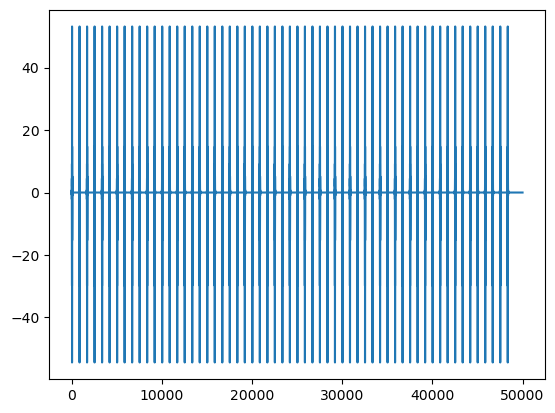

In [22]:
f,ax = plt.subplots()
#ax.plot(np.arange(len(signal_l)),signal_l)
ax.plot(np.arange(len(signal_l)),impsim(fs,varsize,fmod,amp_imp,f_center,bandwidth,shift))
plt.show()

In [24]:
def create_signal(alpha, impulse_amplitude):
    fs = 25000
    fmod = 30
    f_center = 5000
    bandwidth = 1500
    shift = 0

    amp_imp = impulse_amplitude
    alfa = alpha
    skala = 0.5

    varsize = 2*fs
    tt_ts = np.linspace(1/fs,varsize/fs,varsize)
    #szum = np.random.normal(0,skala,varsize) #szum Gaussowski
    szum = levy_stable.rvs(alfa,0,0,skala,varsize)  #szum alfa-stabilny

    signal_l = 9*impsim(fs,varsize,fmod,amp_imp,f_center,bandwidth,shift)+szum
    return signal_l

In [27]:
alpha = 1.8
amplitudes = np.linspace(0,20,21)
mc_iterations = 100
data = []
for i in range(mc_iterations):
    data_i = []
    for a in amplitudes:
        data_i.append(create_signal(alpha, a))
    data.append(np.array(data_i))

In [30]:
np.concatenate(data).shape

(2100, 50000)

In [50]:
#dim * delay should roughly equal len(time_series)/numer_of_periods
dim = 3*833#417# half period
delay = len(data[0][0])//dim
print("delay", delay)
skip = 1#200#0#100
print(dim*delay)
print(len(data[0][0])/24)

tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
point_clouds = tde.transform(np.concatenate(data))

for i in range(0,len(point_clouds)):
    point_clouds[i] = point_clouds[i]-np.mean(point_clouds[i],1)[:, None]
    point_clouds[i] = point_clouds[i]/np.sqrt(np.sum(point_clouds[i]**2, 1))[:, None]

print(np.array(point_clouds).shape)
print(len(point_clouds[0]))    

delay 20
49980
2083.3333333333335
(2100, 40, 2499)
40


In [56]:
point_clouds[0].shape

(40, 2499)

In [58]:
pds = []
weighted = False
for pc in point_clouds:
    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)

    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    pds.append(pd)


In [83]:
start = min([np.min(d) for d in pds])-0.005
end = max([np.max(d) for d in pds])+0.005
print(start,end)
x = np.linspace(start,end,1000)
bc = BettiCurve(predefined_grid=x)
betti_curves = bc.fit_transform(pds)
avg_bc = []
for i in range(21):
    avg_bc.append(np.mean(betti_curves[i::21],axis=0))
avg_bc=np.array(avg_bc)


1.121854639249838 1.4324911292345113


In [84]:
mds = MDS(n_components=2)
emb =mds.fit_transform(betti_curves)


In [85]:
t = []
for i in range(mc_iterations):
    t=t+[i]*21

t=list(range(0,21))*mc_iterations
t=np.array(t)
t

array([ 0,  1,  2, ..., 18, 19, 20])

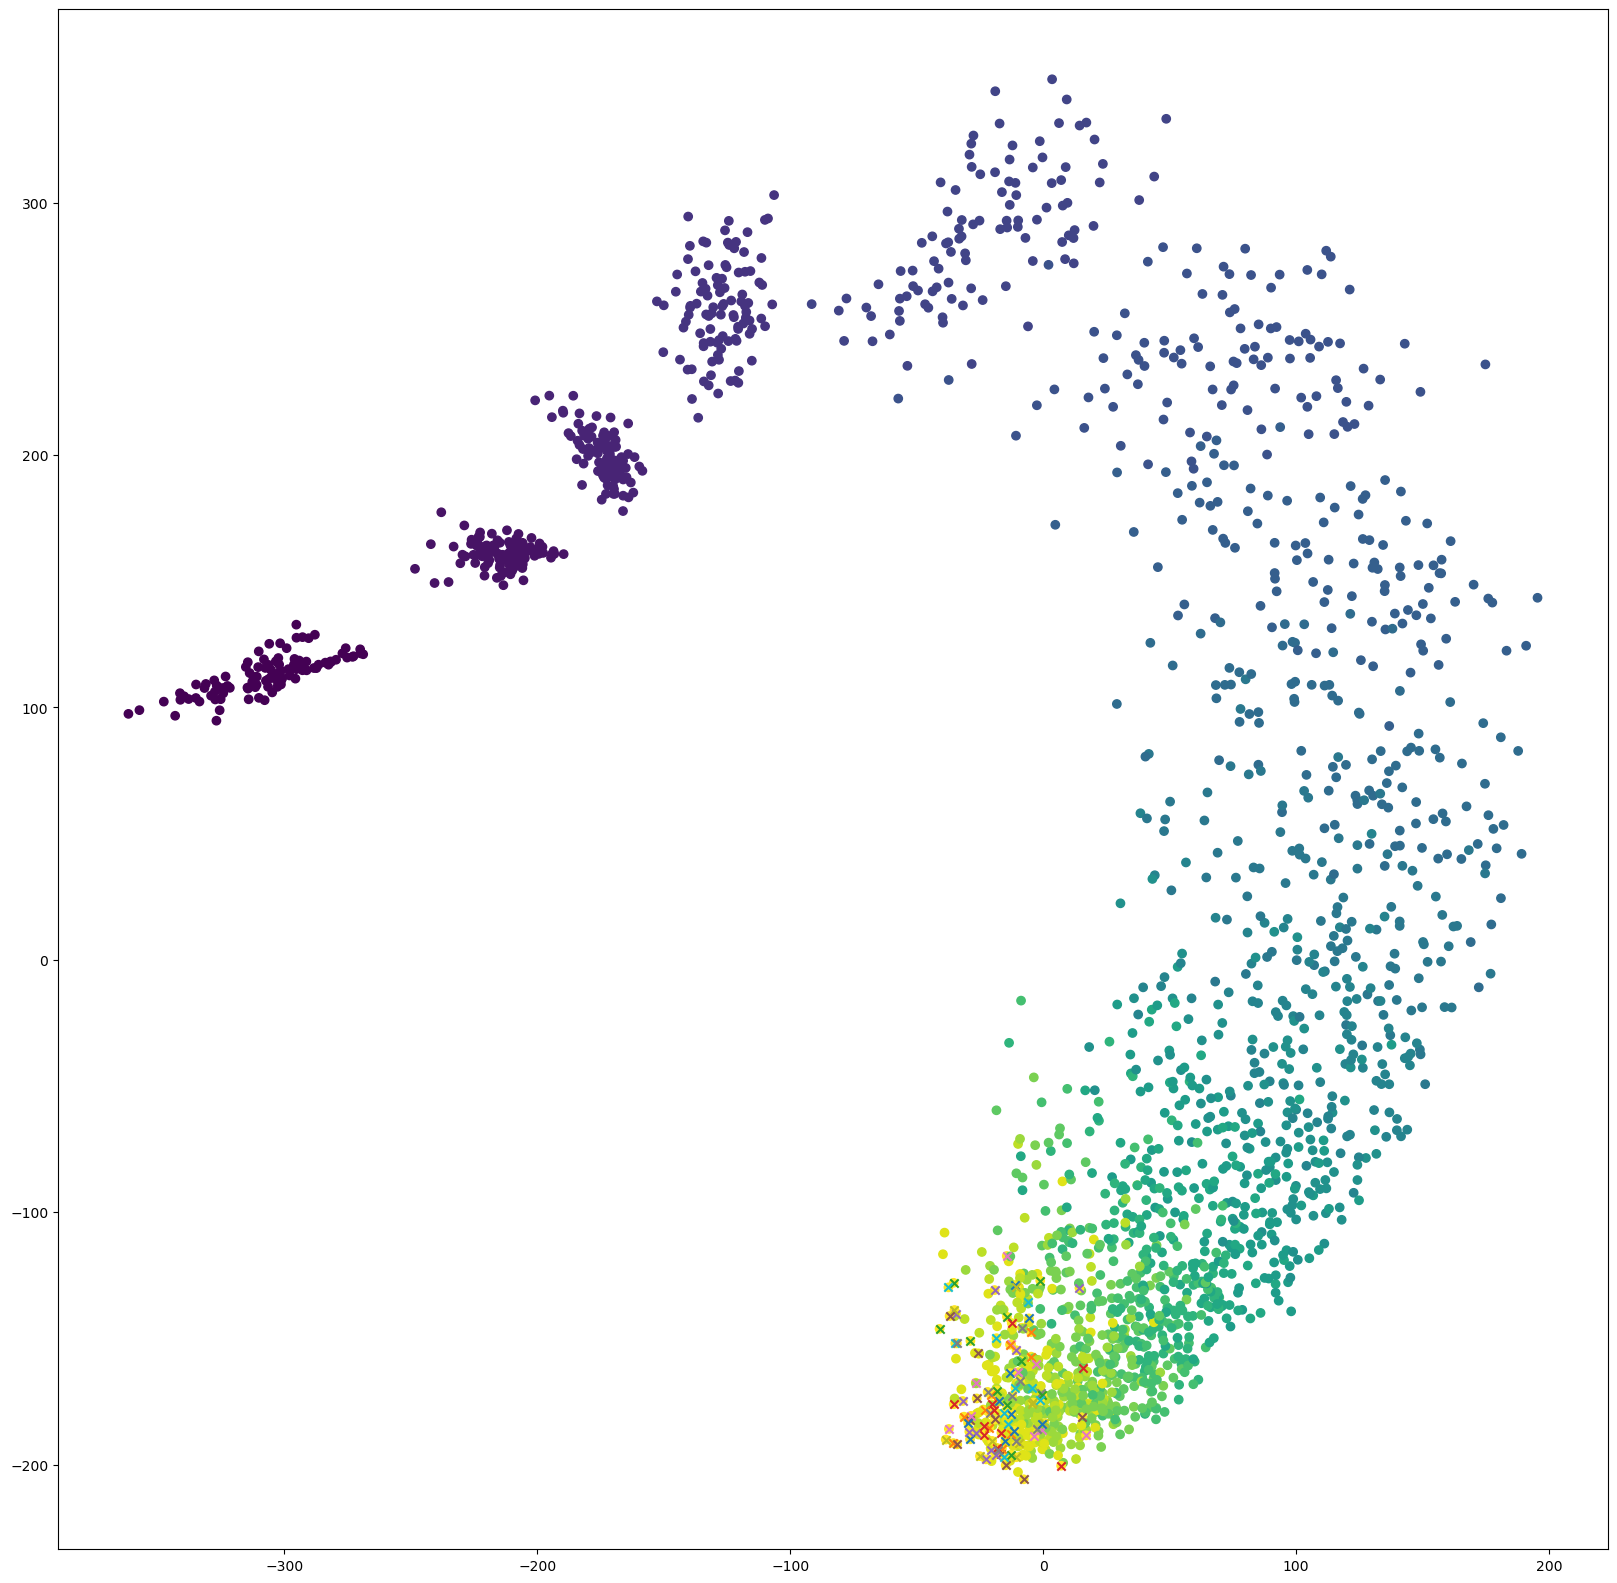

In [86]:

f,ax = plt.subplots(figsize = (20,20))



ax.scatter(emb[:,0],emb[:,1], marker = "o", c=t, label="malfunctioning machine {}".format(i))
#for i in range(0,len(emb)):
    
    #ax.annotate("{}".format(i),(emb[i,0],emb[i,1]))

for i in range(mc_iterations):
    ax.scatter(emb[21*i+20,0],emb[21*i+20,1], marker = "x", label="well-working machine")


#ax.legend()

#plt.savefig("data221214_alpha18_MDS-from-PI_density_dim{}_delay{}.pdf".format(dim, delay))
plt.show()

In [87]:
pca = PCA(n_components=3)
emb = pca.fit_transform(betti_curves)

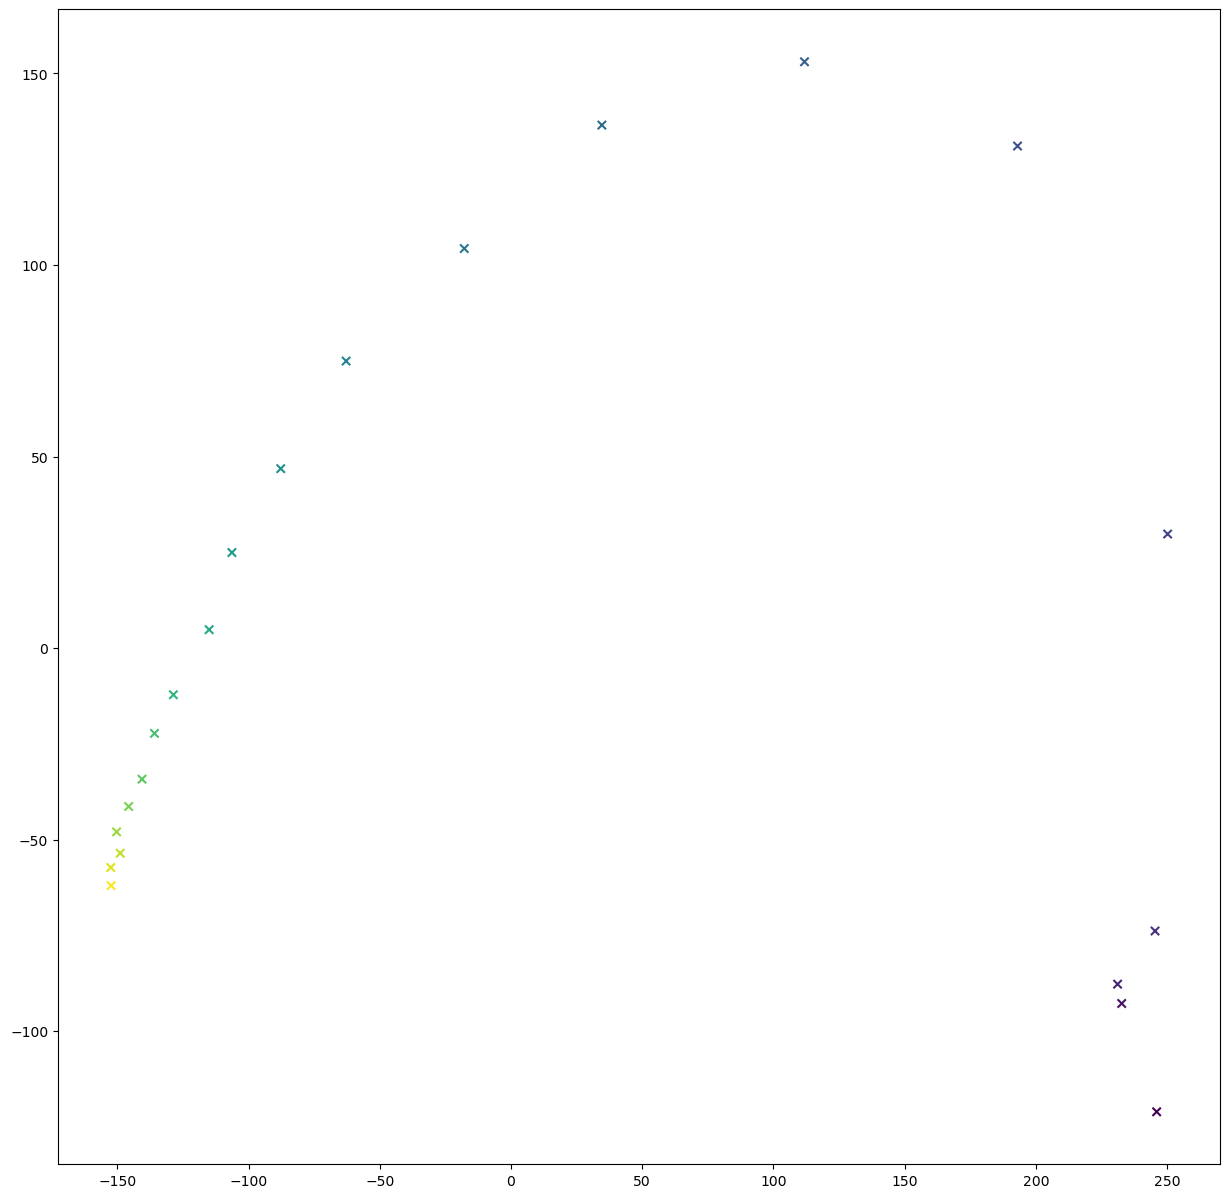

[0.67055452 0.16585307 0.05972177]


In [89]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot()
#ax.scatter(emb[:,0],emb[:,1],  marker = "o", c=t, label="malfunctioning machine {}".format(i))
#for i in range(0,len(emb)):    
    #ax.scatter(emb[i,0],emb[i,1], emb[i,2], marker = "o", c=t[i], label="malfunctioning machine {}".format(i))
#    ax.text(emb[i,0],emb[i,1], "{}".format(i))

#for i in range(mc_iterations):
    #ax.scatter(emb[21*i+20,0],emb[21*i+20,1], marker = "x", label="well-working machine")

avg_emb = pca.transform(avg_bc)
ax.scatter(avg_emb[:,0],avg_emb[:,1], c= range(0,21), marker="x")
#ax.legend()
#plt.savefig("data221214_alpha18_PCA-from-PI_dim{}_delay{}.pdf".format(dim, delay))
#plt.colorbar()
plt.show()
print(pca.explained_variance_ratio_)